## Packages and Assets

In [60]:
import keras.models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.text import tokenizer_from_json
from keras.utils import pad_sequences
import pandas as pd


import plotly.express as px



## Dependencies

In [61]:
# test_padded = pd.read_csv('../../assets/data/splits/test/padded.csv')
test_pp = pd.read_csv('../../assets/data/splits/test/preprocessed.csv')
test_pp

,title,tags,url,time,Open,High,Low,Close,Adj Close,Volume,profit,profit (%),label
0,petrobras reajusta hoje preco medio gasolina d...,"['Empresas', 'Gasolina', 'Petrobras']",https://www.moneytimes.com.br/petrobras-reajus...,12:45:00,19.879999,20.820000,19.820000,20.440001,7.523751,67418700,0.028169,2.82,2
1,petrobras precificara maior oferta acoes decad...,"['Ações', 'BNDES', 'CVM', 'Empresas', 'Ofertas...",https://www.moneytimes.com.br/petrobras-preve-...,15:20:00,29.730000,29.809999,29.270000,29.290001,11.620691,32491500,-0.014800,-1.48,0
2,tradingview ideias analises nesta quinta,"['Empresas', 'Internacional', 'Mercados', 'Pet...",https://www.moneytimes.com.br/tradingview-idei...,09:36:00,25.400000,25.540001,25.320000,25.540001,9.807138,40109000,0.005512,0.55,2
3,petrobras petr4 petrorio prio3 destaques mercado,"['Petrobras (PETR4)', 'PetroRecôncavo (RECV3)'...",https://www.suno.com.br/noticias/petrobras-pet...,10:08:00,29.280001,29.570000,28.799999,29.360001,14.332482,98989300,0.002732,0.27,2
4,maior demanda combustiveis america latina ajud...,"['Argentina', 'Bloomberg', 'Brasil', 'Colômbia...",https://www.moneytimes.com.br/maior-demanda-po...,13:08:00,23.150000,23.600000,23.139999,23.370001,9.272458,101769600,0.009503,0.95,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,senado aprova projeto cria conta estabilizacao...,"['Câmara dos Deputados', 'Combustíveis', 'Dies...",https://www.moneytimes.com.br/senado-aprova-pr...,16:26:00,32.599998,34.599998,32.520000,33.700001,16.451113,136437700,0.033742,3.37,2
440,petrobras petr4 gerente rh suspeito insider re...,['Petrobras (PETR4)'],https://www.suno.com.br/noticias/petrobras-pet...,08:59:00,24.129999,24.200001,23.680000,24.040001,9.538484,40454400,-0.003730,-0.37,0
441,george washington indias orientais petrobras r...,"['Opinião', 'Petrobras', 'Terraço Econômico']",https://www.moneytimes.com.br/george-washingto...,11:30:00,16.100000,16.100000,16.100000,16.100000,5.926244,0,0.000000,0.00,1
442,anp adia chamada publica alocacao capacidade g...,"['ANP', 'Bolívia', 'Brasil', 'Empresas', 'Gás'...",https://www.moneytimes.com.br/anp-adia-chamada...,14:56:00,13.150000,13.740000,12.830000,13.380000,5.308463,110947200,0.017490,1.75,2


In [62]:
lstm_model = keras.models.load_model('../../assets/deep_assets/lstm_model')
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 25)             115600    
                                                                 
 lstm_2 (LSTM)               (None, 8, 32)             7424      
                                                                 
 dropout_2 (Dropout)         (None, 8, 32)             0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 132,499
Trainable params: 132,499
Non-tr

In [63]:
bilstm_model = keras.models.load_model('../../assets/deep_assets/bilstm_model')
bilstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 25)             115600    
                                                                 
 bidirectional_2 (Bidirectio  (None, 8, 32)            5376      
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 8, 32)             0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 3)                

In [64]:
# Load the tokenizer from the file
with open('../../assets/deep_assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
    word_index = tokenizer.word_index

## Predictions

### Functions

In [65]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text


def show_confusion_matrix(cm):
    print("Confusion Matrix")
    plt.figure(figsize=(10, 7))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')
    plt.show()

### Preparing Input

In [66]:
X_test = test_pp.title
y_test = test_pp.to_numpy()[:, -1]

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=8, padding='post', truncating='post')
test_padded

array([[   2,  633,  127, ...,   11,   15,   28],
       [   2,    1,  104, ..., 3549,    3,  145],
       [ 315,  640,  641, ...,    0,    0,    0],
       ...,
       [2746,    1,    1, ..., 1767,    1,    0],
       [  52,  545, 1890, ..., 1564,  784,    1],
       [  11,  657,   36, ...,   44,  497,    0]])

### Best LSTM Model

#### Predict

In [67]:
index_word = index2word(word_index)

In [68]:
pred_prob = lstm_model.predict(test_padded)

14/14 [==============================] - 4s 4ms/step


In [69]:
# y_pred = [1 if p > 0.5 else 0 for p in pred_prob]
y_pred = np.argmax(pred_prob, axis=1)

#### Results

In [70]:
df_results = pd.DataFrame()
X_test = list(X_test)
y_test = list(y_test)
df_results['sequence'] = test_sequences
df_results['X_test'] = X_test
df_results['seq2text'] = df_results['sequence'].apply(lambda x: seq2text(x, index_word))
df_results['y_pred'] = y_pred
df_results['y_true'] = y_test
df_results

,sequence,X_test,seq2text,y_pred,y_true
0,"[2, 633, 127, 18, 479, 11, 15, 28]",petrobras reajusta hoje preco medio gasolina d...,"[petrobras, reajusta, hoje, preco, medio, gaso...",2,2
1,"[2, 1, 104, 48, 8, 3549, 3, 145]",petrobras precificara maior oferta acoes decad...,"[petrobras, <OOV>, maior, oferta, acoes, decad...",0,0
2,"[315, 640, 641, 49, 184]",tradingview ideias analises nesta quinta,"[tradingview, ideias, analises, nesta, quinta]",2,2
3,"[2, 4, 157, 324, 59, 20]",petrobras petr4 petrorio prio3 destaques mercado,"[petrobras, petr4, petrorio, prio3, destaques,...",2,2
4,"[104, 346, 32, 298, 590, 598, 28, 80]",maior demanda combustiveis america latina ajud...,"[maior, demanda, combustiveis, america, latina...",2,2
...,...,...,...,...,...
439,"[516, 77, 197, 527, 1333, 948, 27, 32]",senado aprova projeto cria conta estabilizacao...,"[senado, aprova, projeto, cria, conta, estabil...",0,2
440,"[2, 4, 1117, 3362, 1679, 1328, 1, 481]",petrobras petr4 gerente rh suspeito insider re...,"[petrobras, petr4, gerente, rh, suspeito, insi...",0,0
441,"[2746, 1, 1, 1, 2, 1767, 1]",george washington indias orientais petrobras r...,"[george, <OOV>, <OOV>, <OOV>, petrobras, relac...",0,1
442,"[52, 545, 1890, 578, 1, 1564, 784, 1, 2199]",anp adia chamada publica alocacao capacidade g...,"[anp, adia, chamada, publica, <OOV>, capacidad...",0,2


In [71]:
# accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# precision = precision_score(average='macro', y_true=y_test, y_pred=y_pred)
# recall = recall_score(average='macro', y_true=y_test, y_pred=y_pred)
# f1 = f1_score(average='macro', y_true=y_test, y_pred=y_pred)
# cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.48      0.58      0.53       214
           1       0.10      0.09      0.09        35
           2       0.42      0.34      0.38       195

    accuracy                           0.44       444
   macro avg       0.34      0.34      0.33       444
weighted avg       0.43      0.44      0.43       444

Confusion Matrix


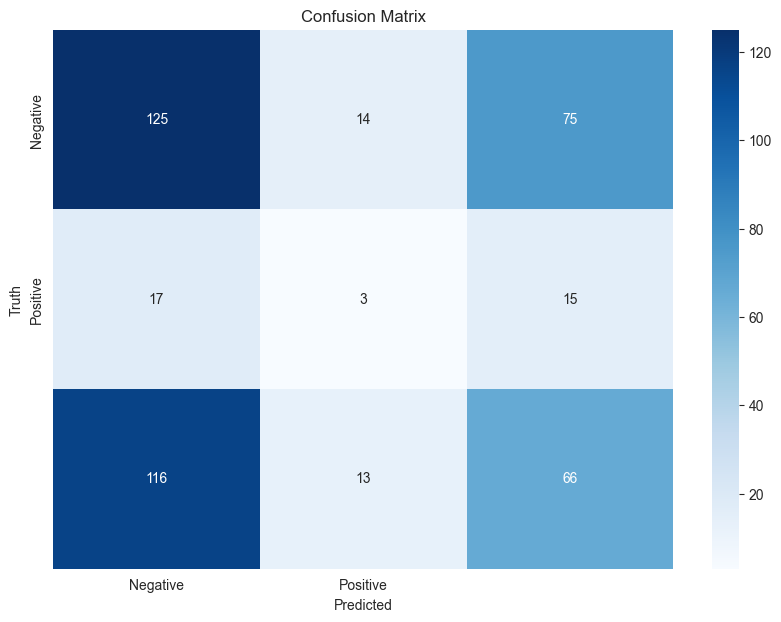

In [72]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
show_confusion_matrix(cm)

### Best BiLSTM Model

#### Predict

In [73]:
index_word = index2word(word_index)

In [74]:
pred_prob = bilstm_model.predict(test_padded)

14/14 [==============================] - 2s 2ms/step


In [75]:
# y_pred = [1 if p > 0.5 else 0 for p in pred_prob]
y_pred = np.argmax(pred_prob, axis=1)

#### Results

In [76]:
df_results = pd.DataFrame()
X_test = list(X_test)
y_test = list(y_test)
df_results['sequence'] = test_sequences
df_results['X_test'] = X_test
df_results['seq2text'] = df_results['sequence'].apply(lambda x: seq2text(x, index_word))
df_results['y_pred'] = y_pred
df_results['y_true'] = y_test
df_results

,sequence,X_test,seq2text,y_pred,y_true
0,"[2, 633, 127, 18, 479, 11, 15, 28]",petrobras reajusta hoje preco medio gasolina d...,"[petrobras, reajusta, hoje, preco, medio, gaso...",2,2
1,"[2, 1, 104, 48, 8, 3549, 3, 145]",petrobras precificara maior oferta acoes decad...,"[petrobras, <OOV>, maior, oferta, acoes, decad...",2,0
2,"[315, 640, 641, 49, 184]",tradingview ideias analises nesta quinta,"[tradingview, ideias, analises, nesta, quinta]",1,2
3,"[2, 4, 157, 324, 59, 20]",petrobras petr4 petrorio prio3 destaques mercado,"[petrobras, petr4, petrorio, prio3, destaques,...",2,2
4,"[104, 346, 32, 298, 590, 598, 28, 80]",maior demanda combustiveis america latina ajud...,"[maior, demanda, combustiveis, america, latina...",1,2
...,...,...,...,...,...
439,"[516, 77, 197, 527, 1333, 948, 27, 32]",senado aprova projeto cria conta estabilizacao...,"[senado, aprova, projeto, cria, conta, estabil...",2,2
440,"[2, 4, 1117, 3362, 1679, 1328, 1, 481]",petrobras petr4 gerente rh suspeito insider re...,"[petrobras, petr4, gerente, rh, suspeito, insi...",2,0
441,"[2746, 1, 1, 1, 2, 1767, 1]",george washington indias orientais petrobras r...,"[george, <OOV>, <OOV>, <OOV>, petrobras, relac...",2,1
442,"[52, 545, 1890, 578, 1, 1564, 784, 1, 2199]",anp adia chamada publica alocacao capacidade g...,"[anp, adia, chamada, publica, <OOV>, capacidad...",2,2


In [77]:
# accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# precision = precision_score(average='macro', y_true=y_test, y_pred=y_pred)
# recall = recall_score(average='macro', y_true=y_test, y_pred=y_pred)
# f1 = f1_score(average='macro', y_true=y_test, y_pred=y_pred)
# cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

In [78]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.49      0.46      0.48       214
           1       0.15      0.11      0.13        35
           2       0.44      0.50      0.47       195

    accuracy                           0.45       444
   macro avg       0.36      0.36      0.36       444
weighted avg       0.44      0.45      0.45       444



In [79]:
recall = recall_score(y_true=y_test, y_pred=y_pred, average=None)
recall

array([0.45794393, 0.11428571, 0.4974359 ])

### Creating dataframe to pass to plotly

In [80]:
df_metrics = pd.DataFrame(index=['Desceu', 'Constante', 'Subiu'])
df_metrics['Acurácia'] = accuracy_score(y_true=y_test, y_pred=y_pred)
df_metrics['Precisão'] = precision_score(y_true=y_test, y_pred=y_pred, average=None)
df_metrics['Recall'] = recall_score(y_true=y_test, y_pred=y_pred, average=None)
df_metrics['F1-Score'] = f1_score(y_true=y_test, y_pred=y_pred, average=None)


df_metrics

,Acurácia,Precisão,Recall,F1-Score
Desceu,0.448198,0.494949,0.457944,0.475728
Constante,0.448198,0.148148,0.114286,0.129032
Subiu,0.448198,0.442922,0.497436,0.468599


In [81]:
df_metrics.iloc[0]

Acurácia    0.448198
Precisão    0.494949
Recall      0.457944
F1-Score    0.475728
Name: Desceu, dtype: float64

In [82]:

fig = px.bar(df_metrics, x=df_metrics.index, y=["Acurácia", "Precisão", "Recall", "F1-Score"],
             barmode="group", title="Desempenho da BiLSTM em relação a precisão, recall e F1-Score", labels={'index': 'Classes', 'value': 'Porcentagem (%)', 'variable': 'Métricas'})

fig.show()



